In [3]:
# importing libraries
from time import time
import multiprocessing
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from glob import glob
import skimage
import torch
import SimpleITK as sitk
import skimage, torch, torchvision
import torchxrayvision as xrv
import torchvision
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import sys
import warnings
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
import random
import logging
import tensorflow as tf
from keras.models import load_model
from tensorflow import keras
from sklearn.model_selection import train_test_split

2023-11-24 14:08:15.425312: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
def bland_altman_plot(y_actual, y_estimetd):

    y_actual = y_actual.reshape((-1,1))
    y_estimetd = y_estimetd.reshape((-1,1))
    error = y_actual - y_estimetd
    x_axis = 0.5 * (y_actual + y_estimetd)
    mean_value = np.mean(error)
    std_value = np.std(error)
    plt.figure(dpi=150)

    plt.plot(x_axis,error,'*')
    plt.axhline(y=mean_value, color='black',label='Mean value')
    plt.axhline(y=mean_value - 1.96 * std_value, color='red',ls='--',label='Upper and Lower 95% CI')
    plt.axhline(y=mean_value + 1.96 * std_value,ls='--',color='red')
    plt.legend()
    plt.xlabel('Averages (years)')
    plt.ylabel('Differences (years)')
    plt.title('The Bland-Altman Representation of Actual and Predicted Ages')

    plt.grid(which='both')
    plt.xlim([x_axis.min(), x_axis.max()])
    plt.ylim([error.min(), error.max()])
    # print(mean_value - 1.96 * std_value)
    # print(mean_value + 1.96 * std_value)
    print("Mean-1.96SD is {:.2f} and  Mean+1.96SD is {:.2f}".format(mean_value-1.96*std_value,mean_value+1.96*std_value))

    return

In [43]:
# calculating metrics
def regression_metrics(y_actual, y_estimetd):
    y_actual = y_actual.reshape((-1,1))
    y_estimetd = y_estimetd.reshape((-1,1))
    error = y_actual - y_estimetd
    rmse = np.sqrt(np.mean(error**2))
    mae = np.mean(np.abs(error))
    r2 = r2_score(y_true=y_actual,y_pred=y_estimetd)
    cr = np.corrcoef(y_actual.T,y_estimetd.T)
    return rmse, mae,r2,cr

209/209 [==============================] - 0s 952us/step
RMSE is: 19.856598318915086, MAE is: 14.964582479737755, R2  is: -0.1783310990957383, correlation coefficient  is 0.39593333246321605
Mean-1.96SD is -43.29 and  Mean+1.96SD is 30.21


(-100.0, 100.0)

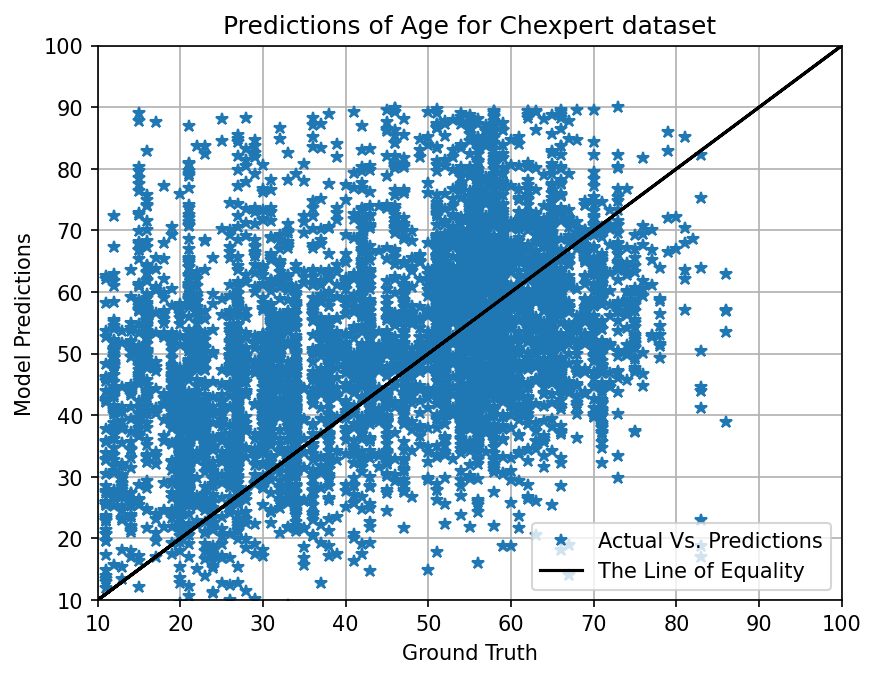

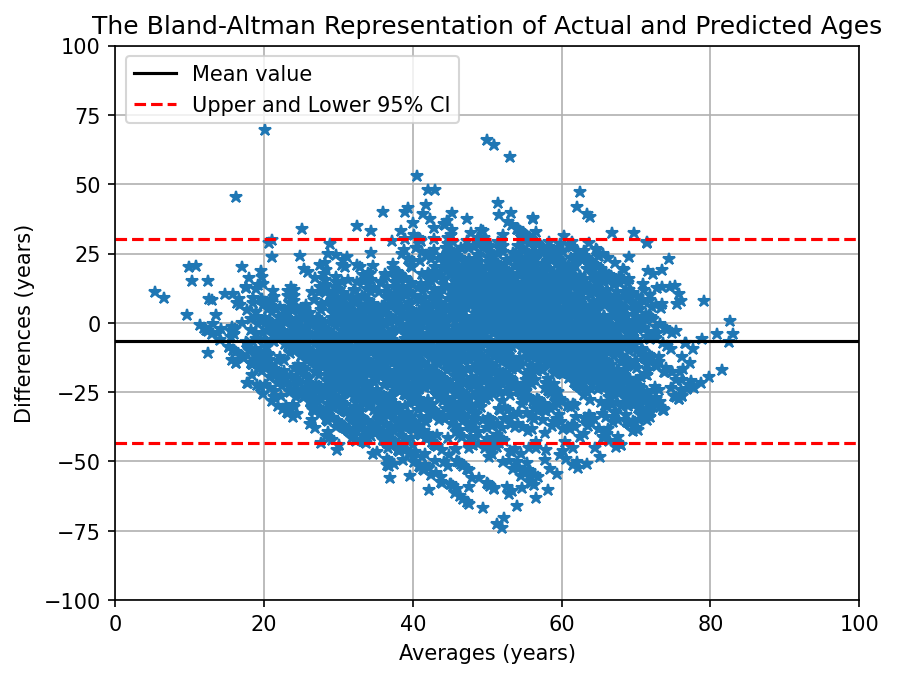

In [44]:
# chexpert age ful model eevaluated by NIH
name = 'chexpert_age_full_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('nih_age_full_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 100])
plt.ylim([-100, 100])

209/209 [==============================] - 0s 995us/step
RMSE is: 22.768038619105127, MAE is: 17.925206350294882, R2  is: -0.680857703779796, correlation coefficient  is 0.05571776380796099
Mean-1.96SD is -48.60 and  Mean+1.96SD is 38.38


(-100.0, 100.0)

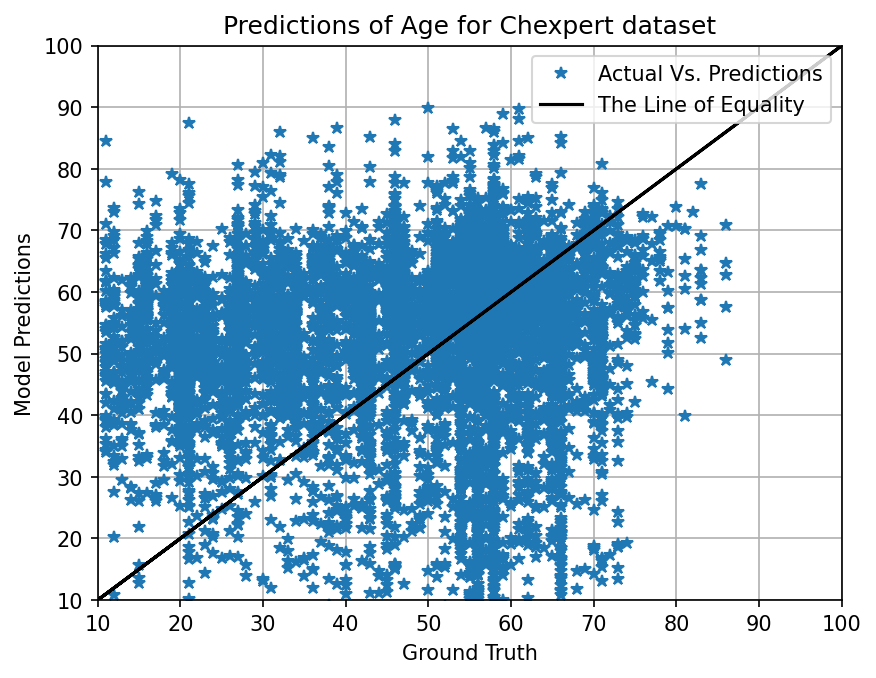

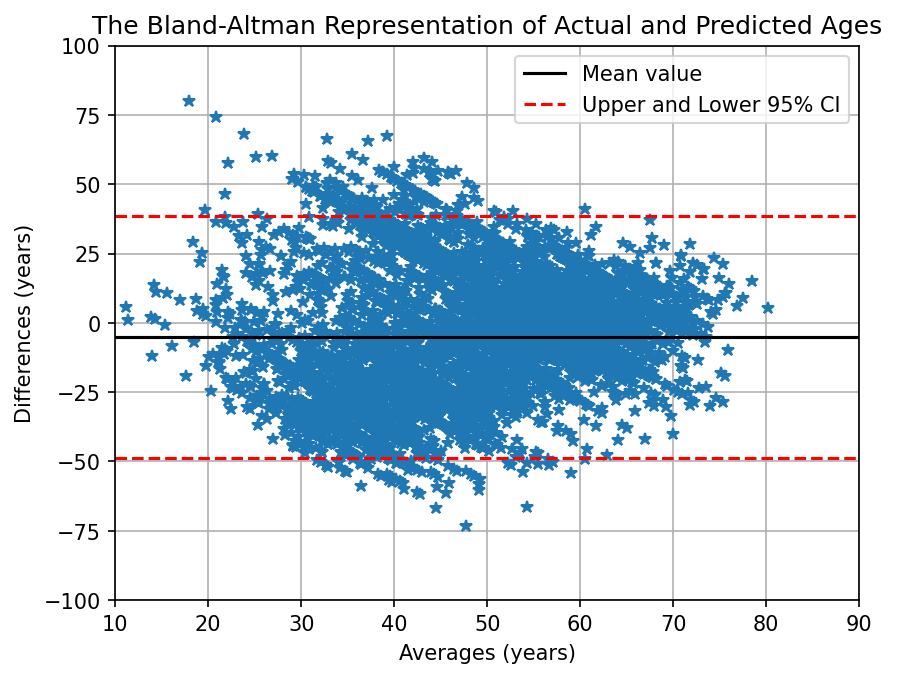

In [45]:
# chexpert first segment age ful model eevaluated by NIH
name = 'chexpert_age_segment_0_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/nih_age_segment_0_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([10, 90])
plt.ylim([-100, 100])

209/209 [==============================] - 0s 1ms/step
RMSE is: 36.31647104816996, MAE is: 23.010183805172886, R2  is: -3.330203746885445, correlation coefficient  is -0.018563216180668276
Mean-1.96SD is -70.69 and  Mean+1.96SD is 71.66


(-100.0, 150.0)

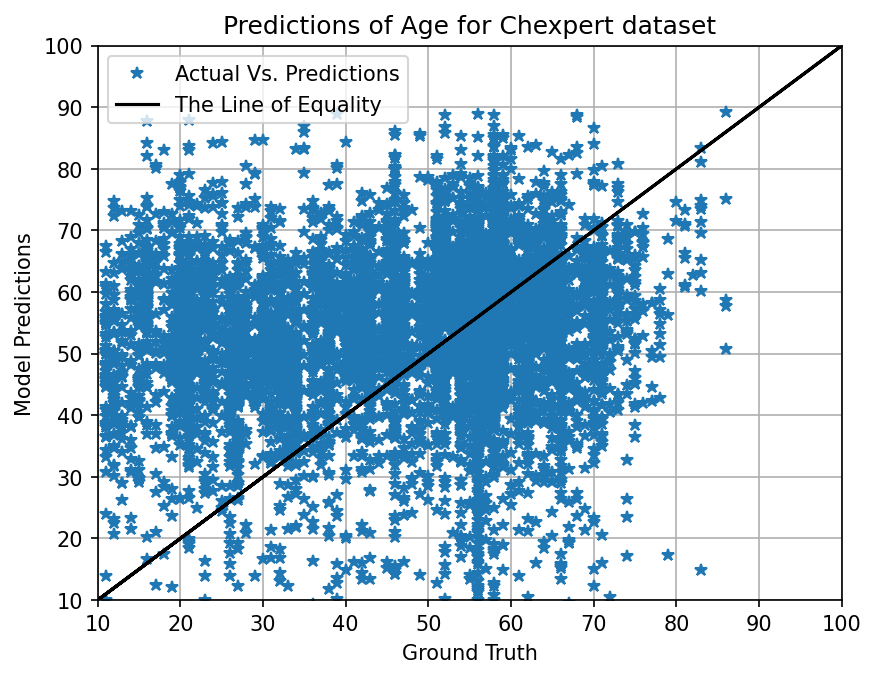

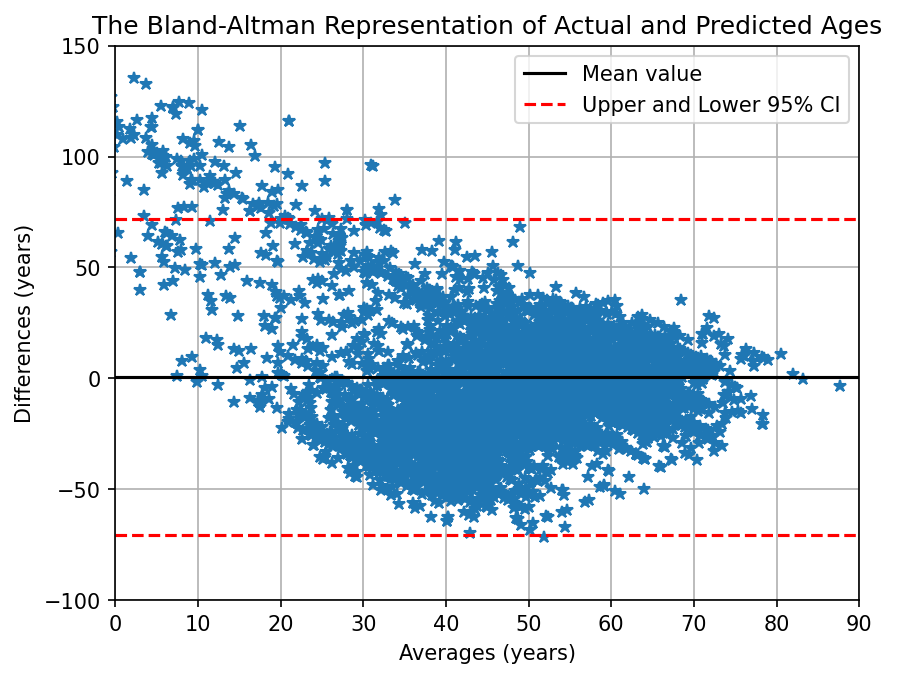

In [46]:
# chexpert second segment age ful model eevaluated by NIH
name = 'chexpert_age_segment_1_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/nih_age_segment_1_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

In [47]:
# chexpert third segment age ful model eevaluated by NIH
name = 'chexpert_age_segment_2_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/nih_age_segment_2_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

209/209 [==============================] - 0s 869us/step
RMSE is: 20.525209515832234, MAE is: 15.757018488575977, R2  is: -0.3648556355118784, correlation coefficient  is 0.11363585504148302
Mean-1.96SD is -44.77 and  Mean+1.96SD is 31.08


(-100.0, 150.0)

209/209 [==============================] - 0s 1ms/step
RMSE is: 27.123929809766096, MAE is: 21.742188953738733, R2  is: -1.205454689414792, correlation coefficient  is 0.2966374074415562
Mean-1.96SD is -56.41 and  Mean+1.96SD is 17.33


(-100.0, 150.0)

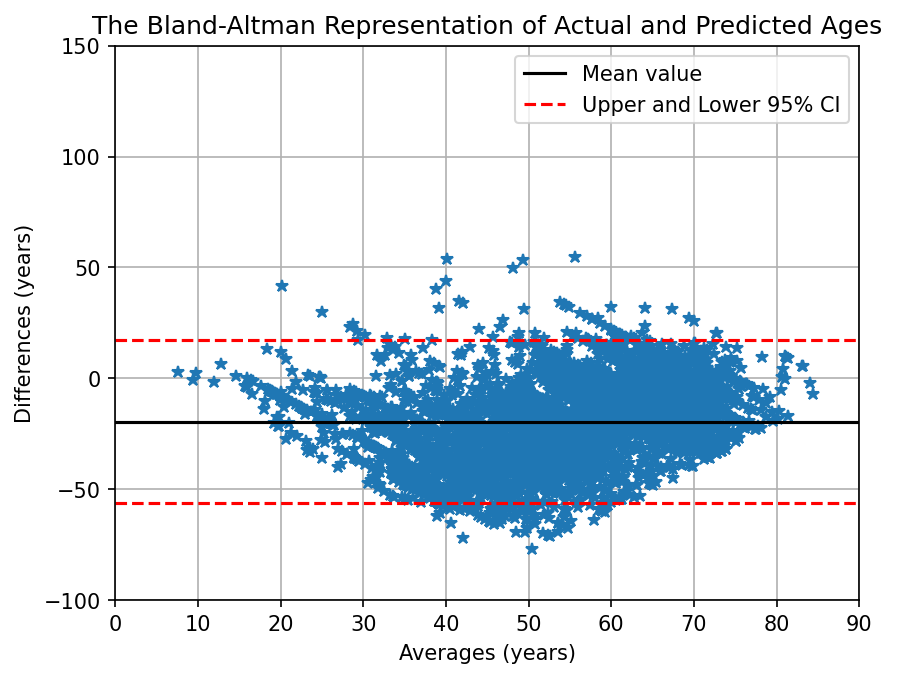

In [48]:
# chexpert second segment age ful model eevaluated by NIH
name = 'chexpert_age_segment_3_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/nih_age_segment_3_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

In [49]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'chexpert_age_full_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_age_full_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

420/420 [==============================] - 0s 956us/step
RMSE is: 14.853533014134769, MAE is: 11.800833521016761, R2  is: 0.0918614058214452, correlation coefficient  is 0.47397374944515075
Mean-1.96SD is -25.57 and  Mean+1.96SD is 31.49


(-100.0, 150.0)

In [50]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'chexpert_age_segment_0_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_age_segment_0_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

420/420 [==============================] - 0s 931us/step
RMSE is: 15.706143598267714, MAE is: 12.704563667283413, R2  is: -0.014620063648676185, correlation coefficient  is 0.2714458572300759
Mean-1.96SD is -28.92 and  Mean+1.96SD is 32.29


(-100.0, 150.0)

420/420 [==============================] - 0s 792us/step
RMSE is: 17.015827456450253, MAE is: 13.657427005577102, R2  is: -0.19085071995839686, correlation coefficient  is 0.2692145666652973
Mean-1.96SD is -26.63 and  Mean+1.96SD is 36.94


(-100.0, 150.0)

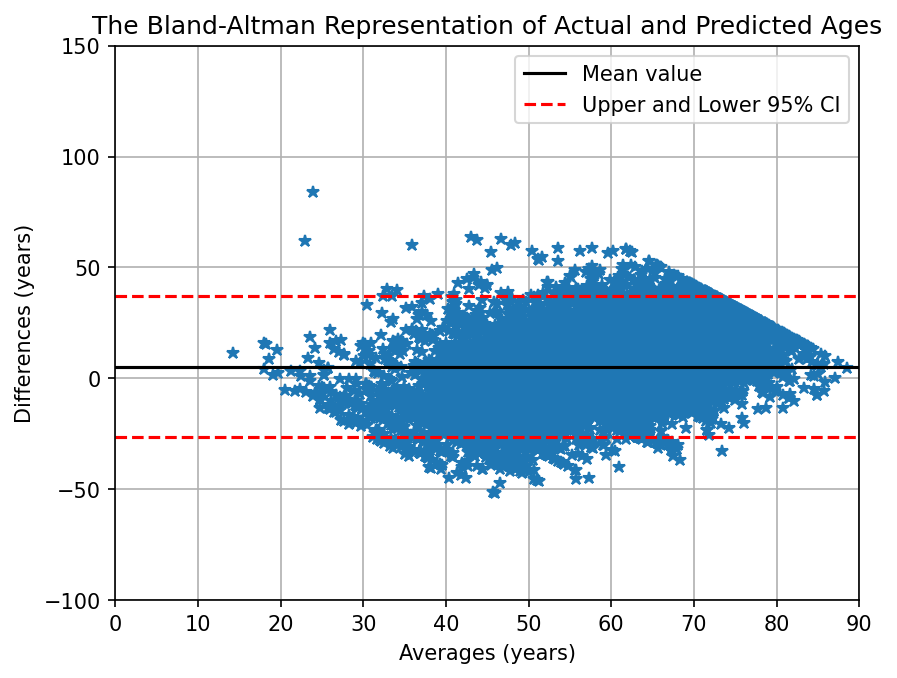

In [51]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'chexpert_age_segment_1_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_age_segment_1_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

In [52]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'chexpert_age_segment_2_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_age_segment_2_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

420/420 [==============================] - 0s 1ms/step
RMSE is: 15.281747739259886, MAE is: 12.330446426080233, R2  is: 0.0395120231659275, correlation coefficient  is 0.2963954795478133
Mean-1.96SD is -28.80 and  Mean+1.96SD is 30.96


(-100.0, 150.0)

420/420 [==============================] - 0s 988us/step
RMSE is: 14.916922056772417, MAE is: 11.824904063038952, R2  is: 0.08470723720229723, correlation coefficient  is 0.38762024531979283
Mean-1.96SD is -30.87 and  Mean+1.96SD is 27.15


(-100.0, 150.0)

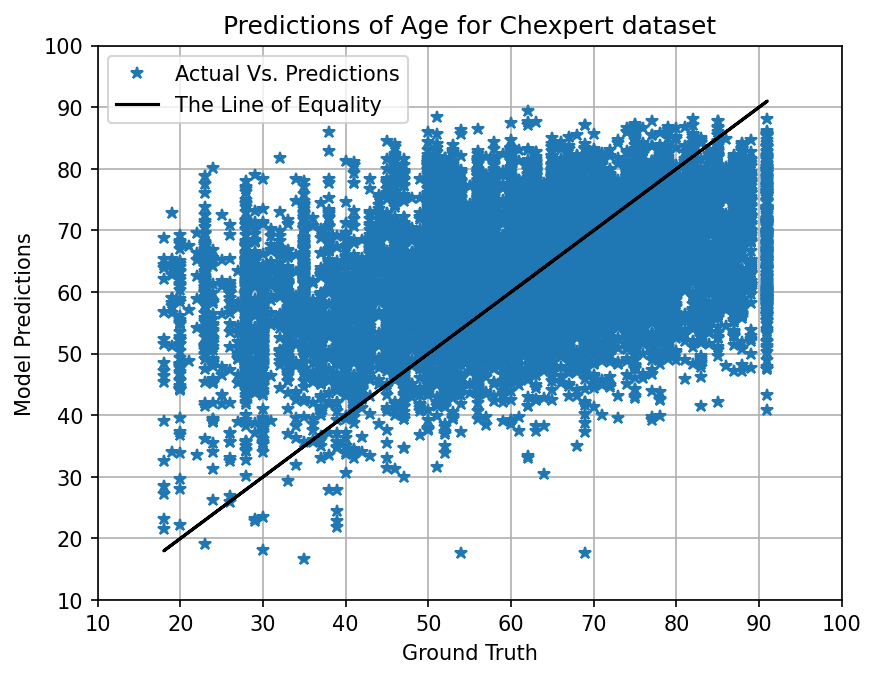

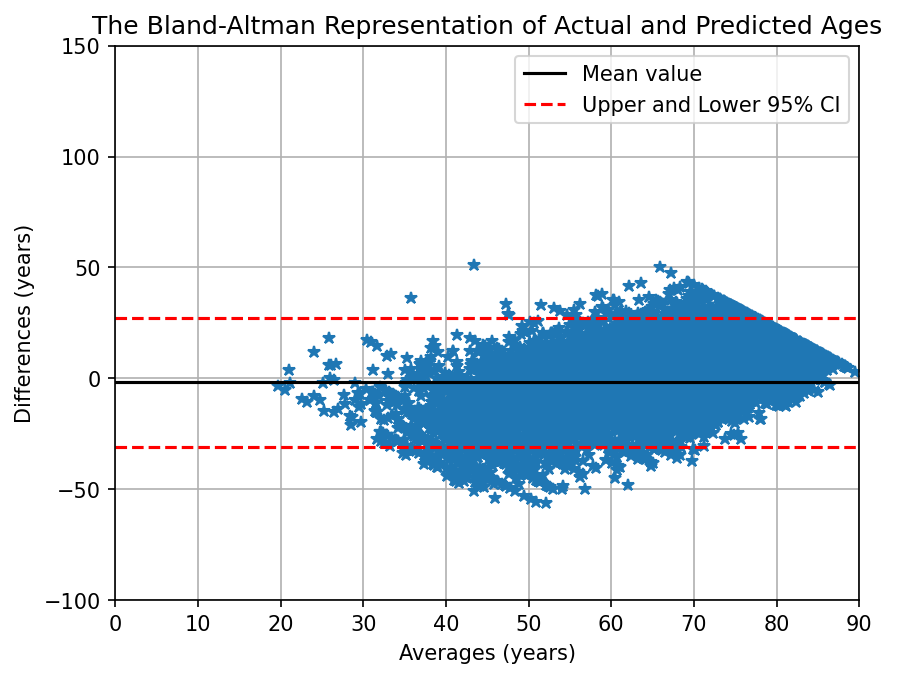

In [53]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'chexpert_age_segment_3_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_age_segment_3_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

In [54]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'mimic_age_full_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_age_full_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

354/354 [==============================] - 1s 1ms/step
RMSE is: 16.166069962291484, MAE is: 12.512841436026171, R2  is: 0.06685060600754911, correlation coefficient  is 0.467480009182851
Mean-1.96SD is -35.27 and  Mean+1.96SD is 24.46


(-100.0, 150.0)

354/354 [==============================] - 0s 1ms/step
RMSE is: 17.904625501542853, MAE is: 13.935390291089785, R2  is: -0.14494871730761472, correlation coefficient  is 0.24940297658764315
Mean-1.96SD is -39.17 and  Mean+1.96SD is 26.38


(-100.0, 150.0)

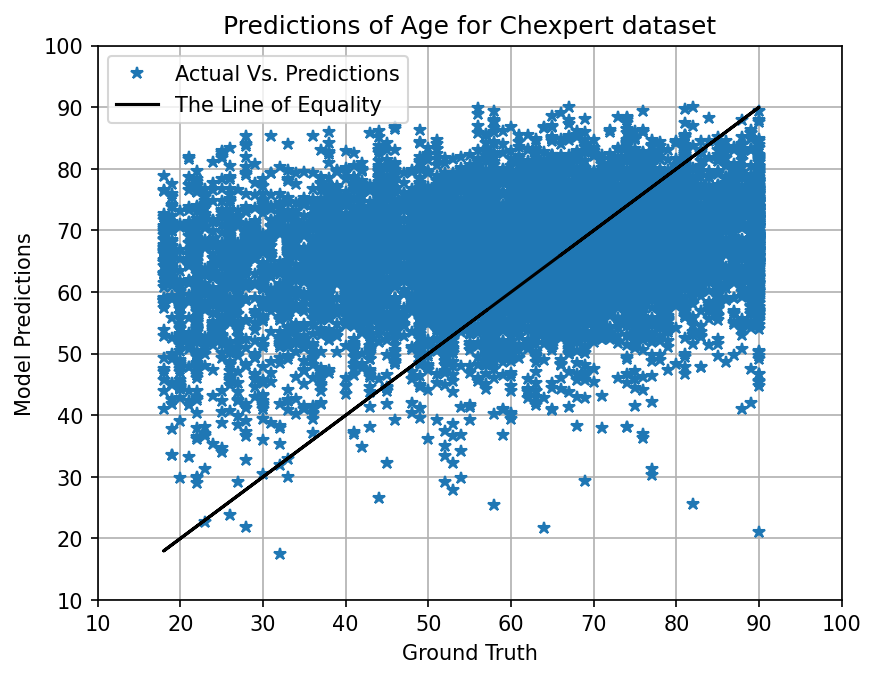

In [55]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'mimic_age_segment_0_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_age_segment_0_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

354/354 [==============================] - 0s 662us/step
RMSE is: 18.431452801590954, MAE is: 14.335941527404245, R2  is: -0.21229300166354603, correlation coefficient  is 0.23449608325184776
Mean-1.96SD is -40.52 and  Mean+1.96SD is 25.07


(-100.0, 150.0)

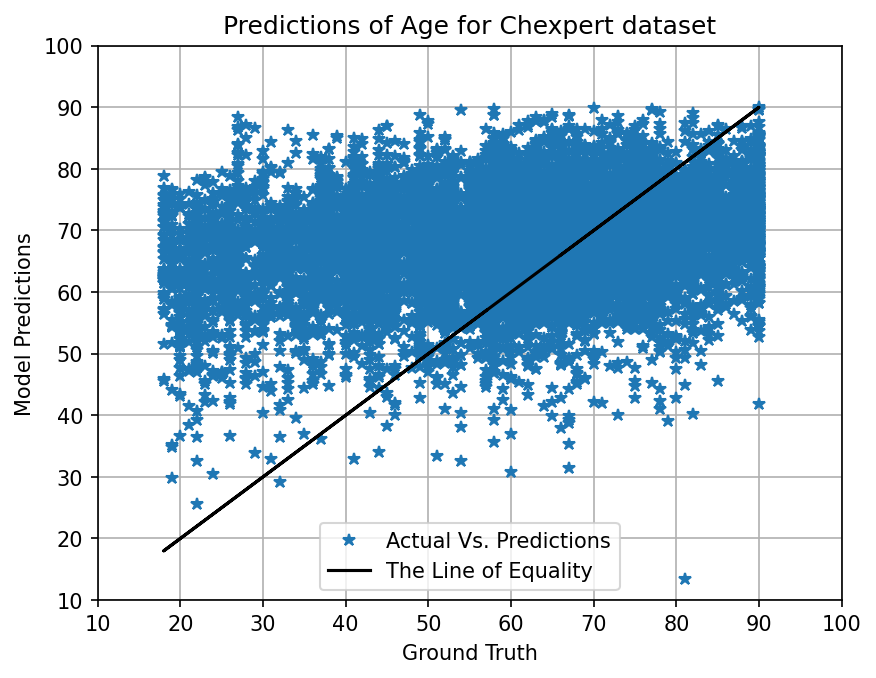

In [56]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'mimic_age_segment_1_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_age_segment_1_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

354/354 [==============================] - 0s 983us/step
RMSE is: 17.417574470095083, MAE is: 13.420799377554815, R2  is: -0.08341351541368636, correlation coefficient  is 0.31136811480915544
Mean-1.96SD is -38.08 and  Mean+1.96SD is 25.87


(-100.0, 150.0)

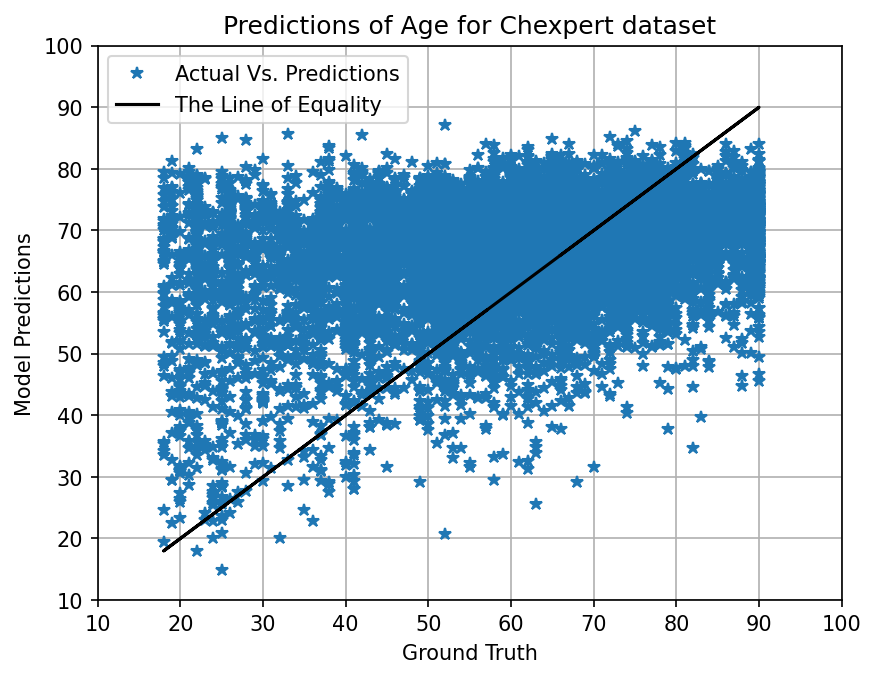

In [57]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'mimic_age_segment_2_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_age_segment_2_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

354/354 [==============================] - 0s 893us/step
RMSE is: 17.417574470095083, MAE is: 13.420799377554815, R2  is: -0.08341351541368636, correlation coefficient  is 0.31136811480915544
Mean-1.96SD is -38.08 and  Mean+1.96SD is 25.87


(-100.0, 150.0)

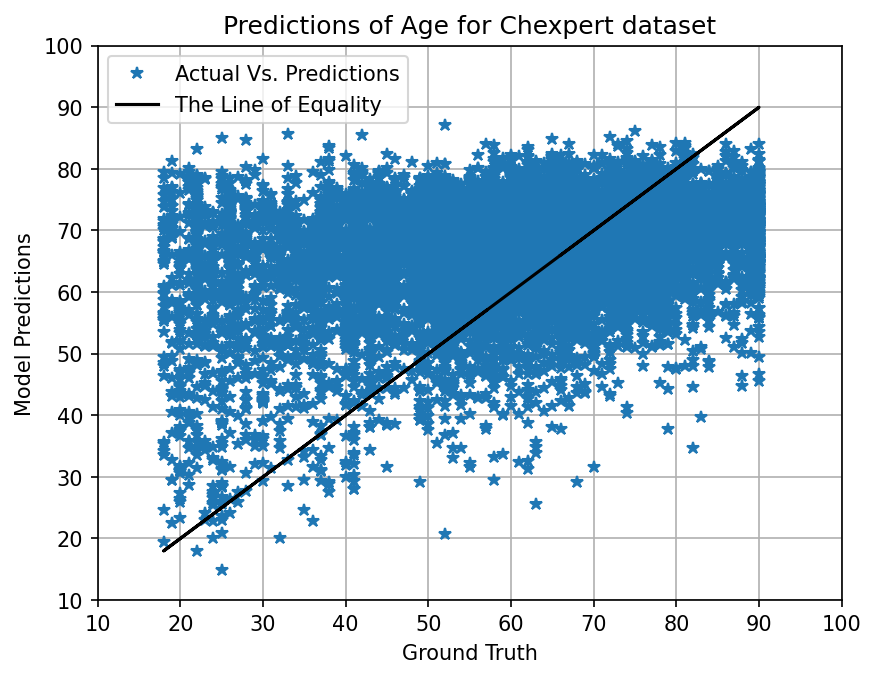

In [58]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'mimic_age_segment_2_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_age_segment_2_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

354/354 [==============================] - 0s 669us/step
RMSE is: 16.305194144555042, MAE is: 12.634792532571108, R2  is: 0.050720244856755525, correlation coefficient  is 0.38859507016499045
Mean-1.96SD is -35.04 and  Mean+1.96SD is 26.81


(-100.0, 150.0)

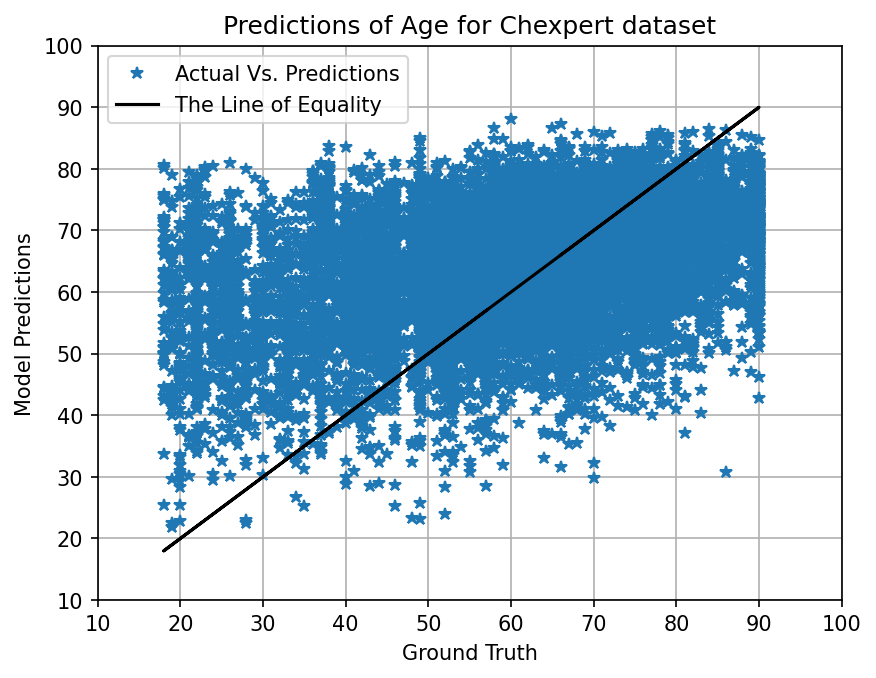

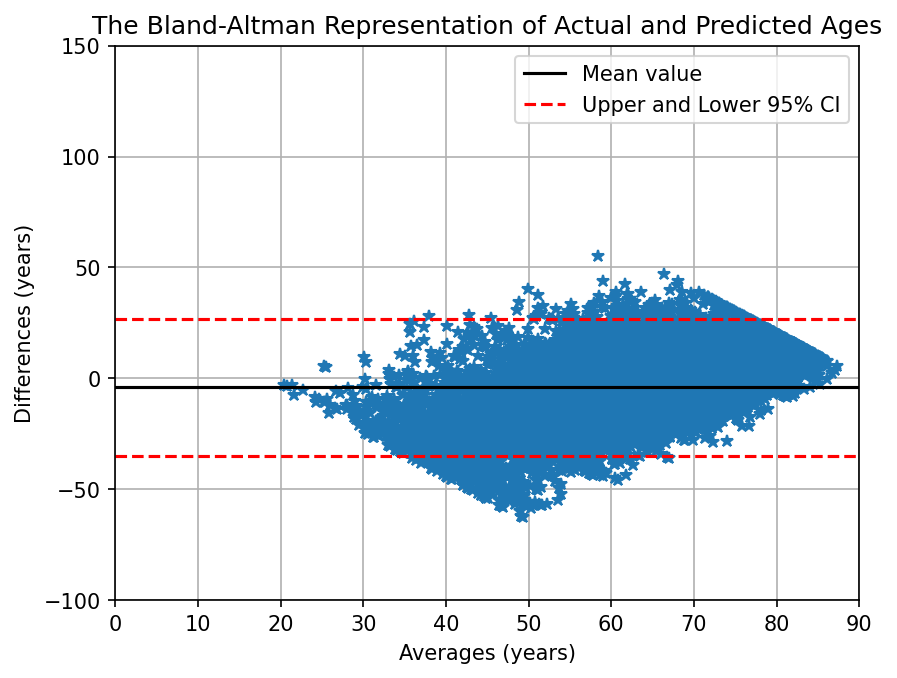

In [59]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'mimic_age_segment_3_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_age_segment_3_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

209/209 [==============================] - 0s 879us/step
RMSE is: 25.3823444273325, MAE is: 20.102660297658556, R2  is: -1.1191499509301246, correlation coefficient  is 0.31513272613838417
Mean-1.96SD is -53.16 and  Mean+1.96SD is 17.33


(-100.0, 150.0)

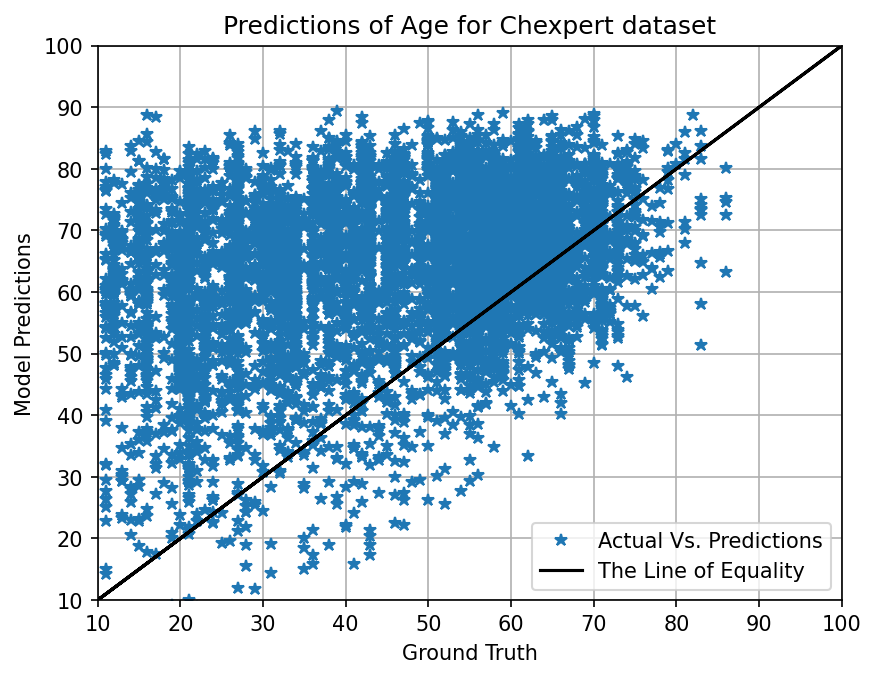

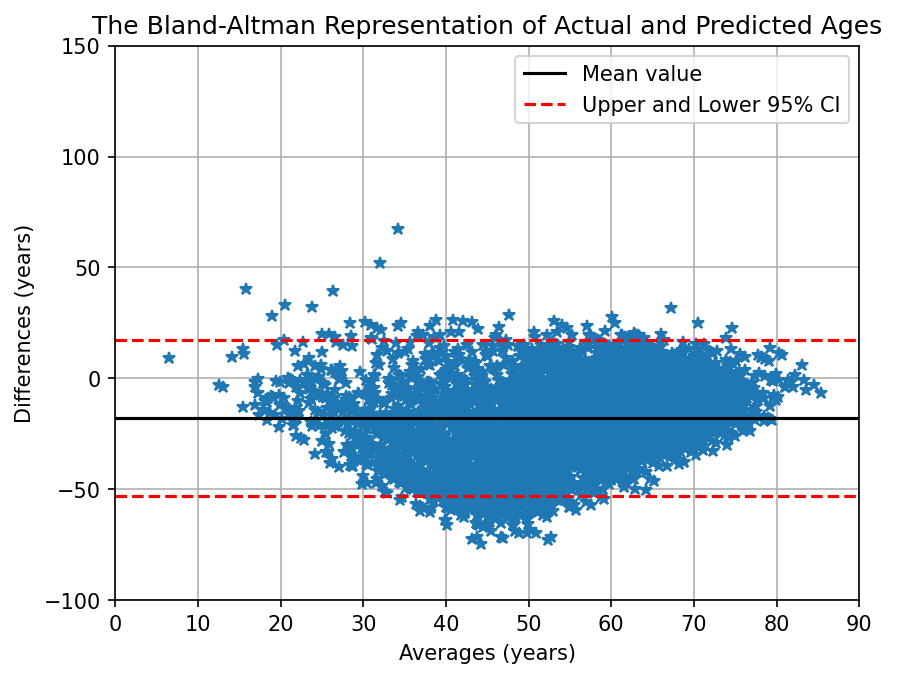

In [60]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'mimic_age_full_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/nih_age_full_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

209/209 [==============================] - 0s 657us/step
RMSE is: 22.434544770839636, MAE is: 17.164036240254273, R2  is: -0.6557933625238213, correlation coefficient  is 0.16965863081564042
Mean-1.96SD is -48.87 and  Mean+1.96SD is 23.06


(-100.0, 150.0)

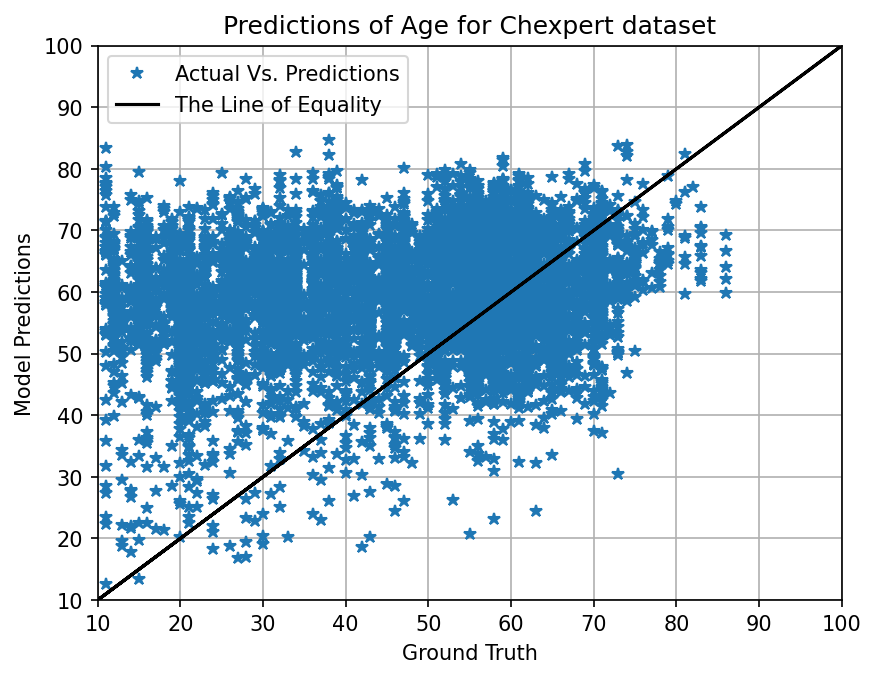

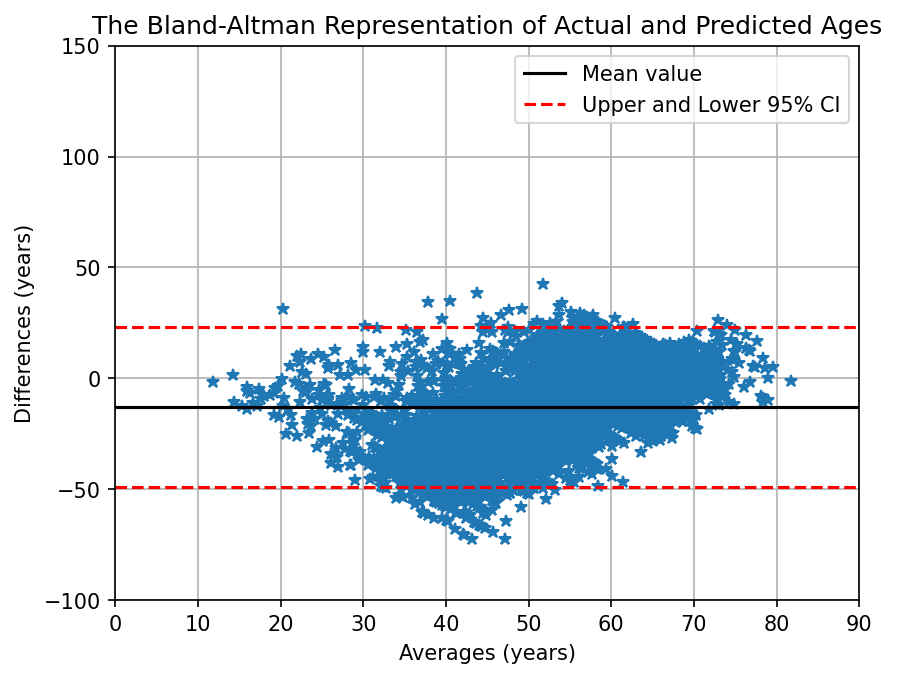

In [61]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'mimic_age_segment_0_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/nih_age_segment_0_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

209/209 [==============================] - 0s 693us/step
RMSE is: 23.236386479443695, MAE is: 17.592278080040952, R2  is: -0.7762692472454, correlation coefficient  is 0.03940192544615689
Mean-1.96SD is -50.94 and  Mean+1.96SD is 26.36


(-100.0, 150.0)

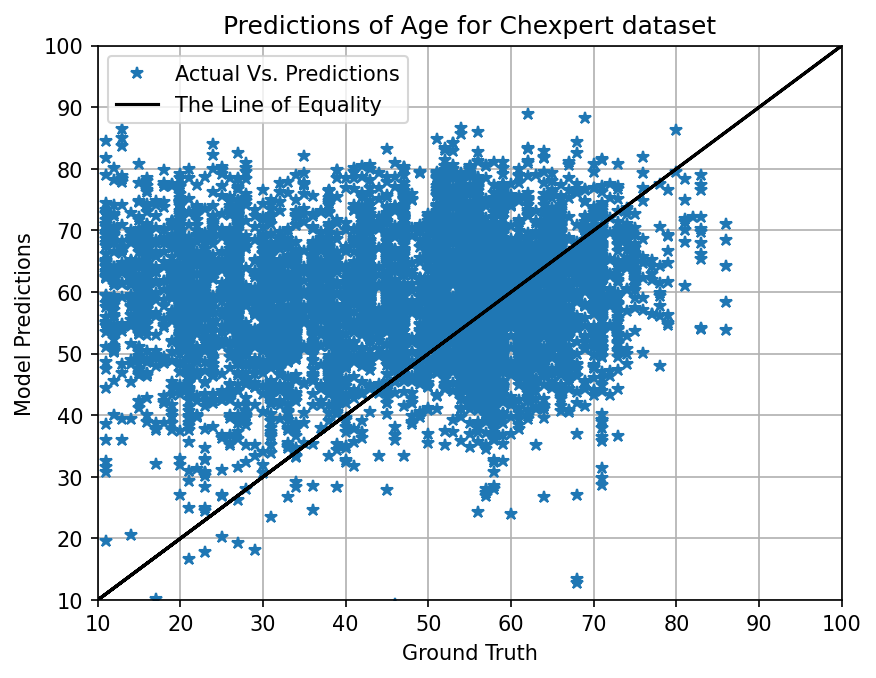

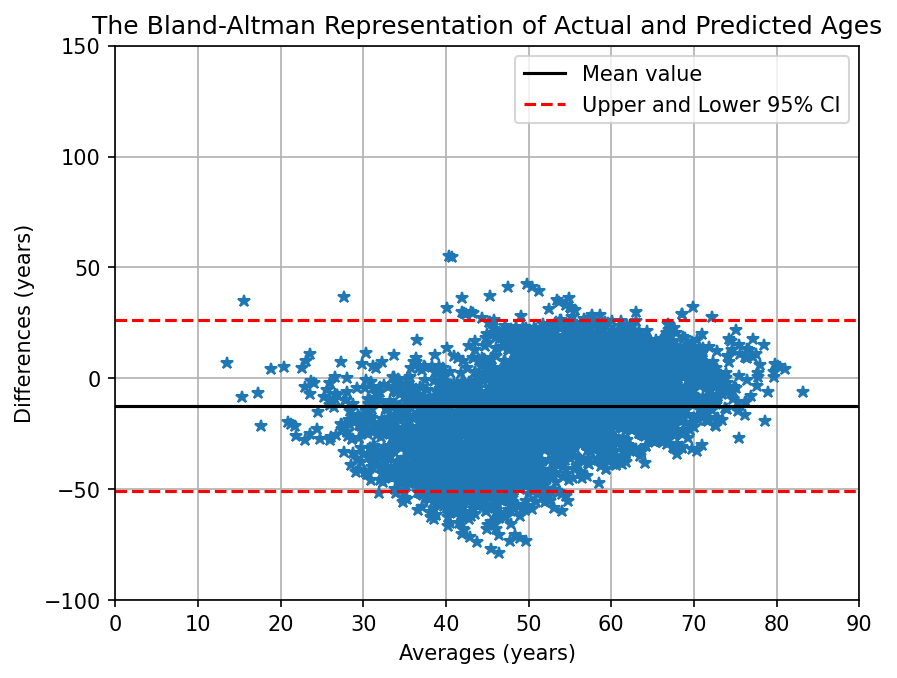

In [62]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'mimic_age_segment_1_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/nih_age_segment_1_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

209/209 [==============================] - 0s 712us/step
RMSE is: 25.082566690176787, MAE is: 19.45429111081667, R2  is: -1.0695216897578566, correlation coefficient  is 0.17268168920637933
Mean-1.96SD is -54.52 and  Mean+1.96SD is 25.07


(-100.0, 150.0)

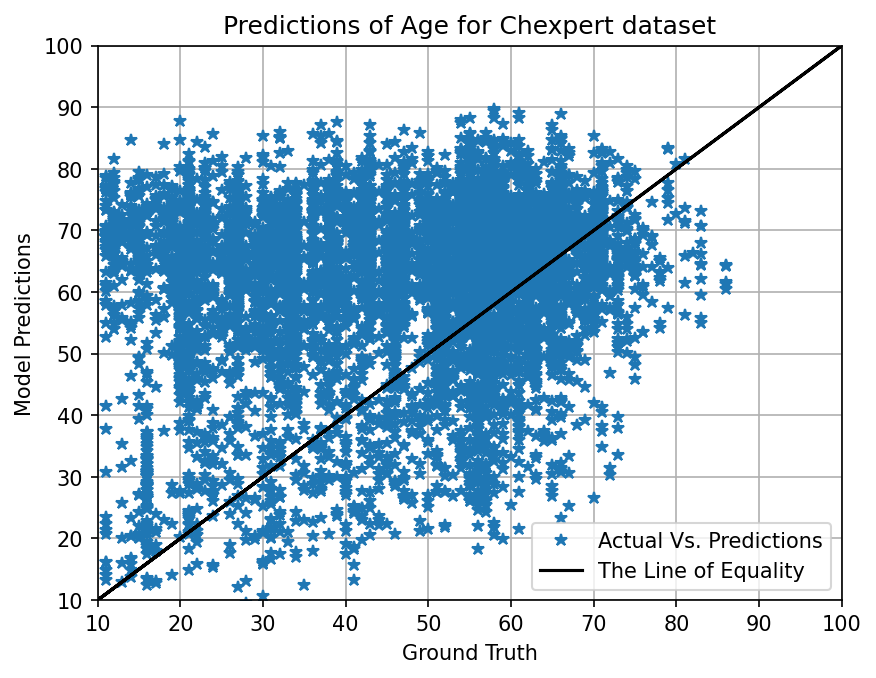

In [63]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'mimic_age_segment_2_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/nih_age_segment_2_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

209/209 [==============================] - 0s 671us/step
RMSE is: 25.082566690176787, MAE is: 19.45429111081667, R2  is: -1.0695216897578566, correlation coefficient  is 0.17268168920637933
Mean-1.96SD is -54.52 and  Mean+1.96SD is 25.07


(-100.0, 150.0)

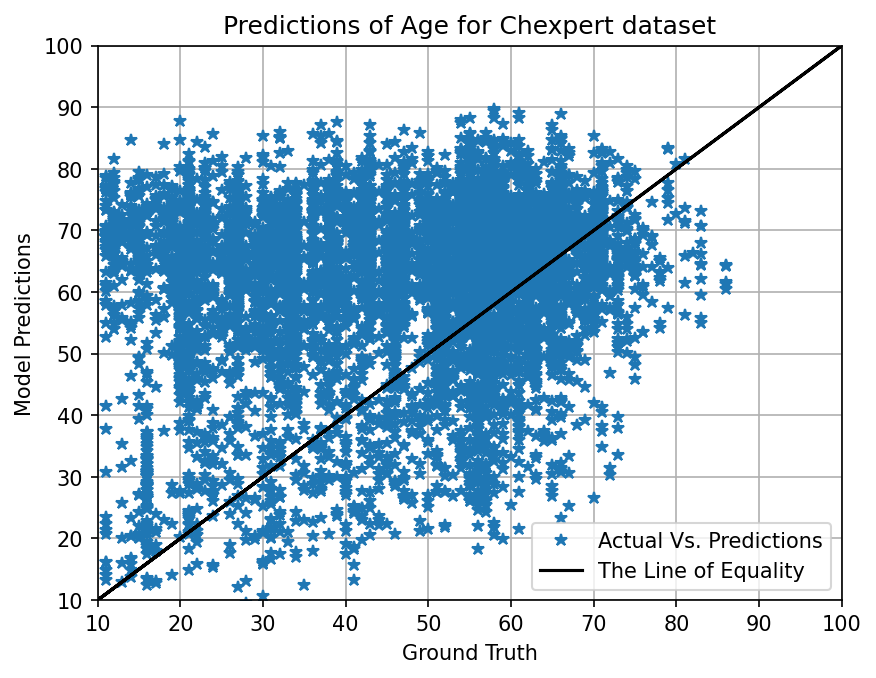

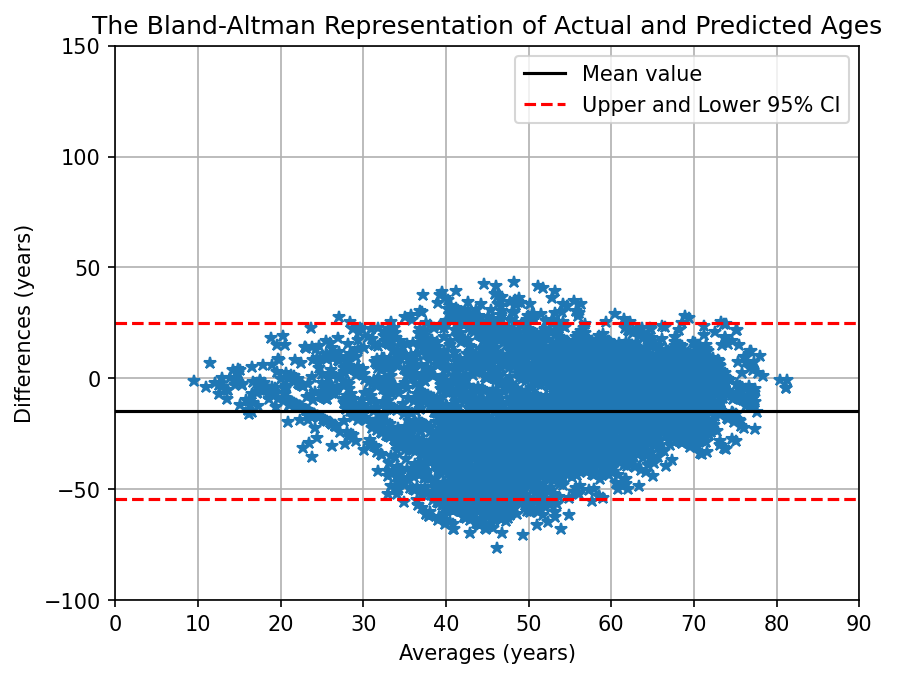

In [64]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'mimic_age_segment_2_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/nih_age_segment_2_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

209/209 [==============================] - 0s 829us/step
RMSE is: 25.32696632702361, MAE is: 19.925595010295744, R2  is: -1.1101738466897708, correlation coefficient  is 0.08512414861433132
Mean-1.96SD is -54.66 and  Mean+1.96SD is 40.86


(-100.0, 150.0)

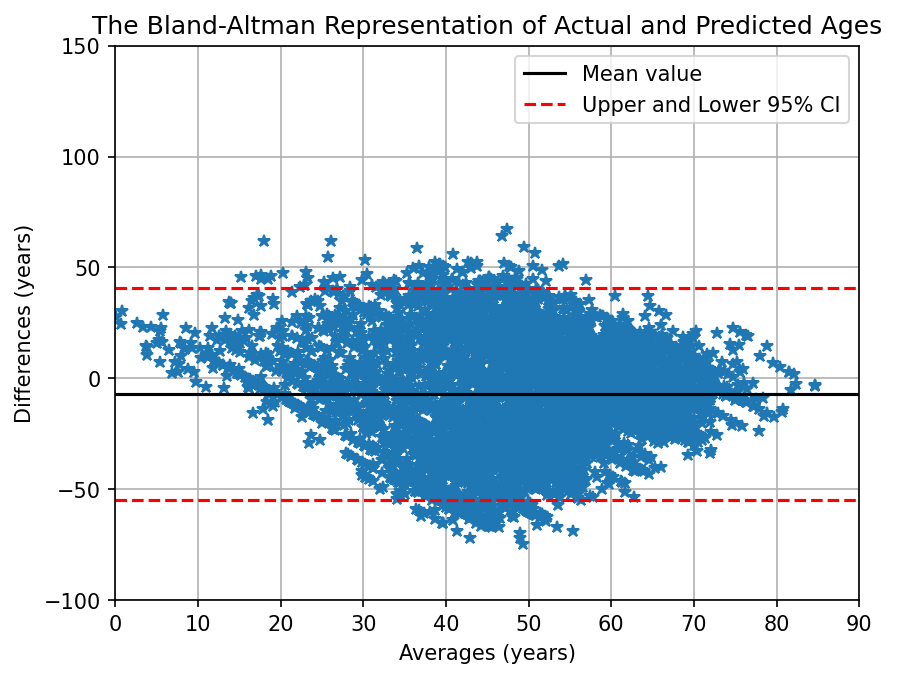

In [65]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'mimic_age_segment_3_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/nih_age_segment_3_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

354/354 [==============================] - 0s 863us/step
RMSE is: 20.215712849412018, MAE is: 16.023888108287988, R2  is: -0.4592187136558925, correlation coefficient  is 0.2240816714715042
Mean-1.96SD is -29.72 and  Mean+1.96SD is 44.24


(-100.0, 150.0)

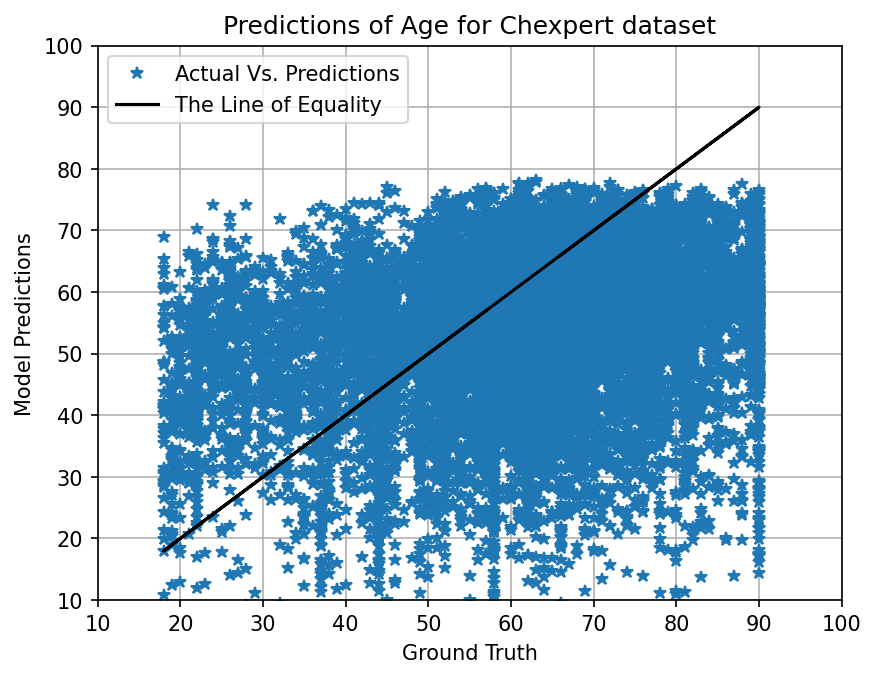

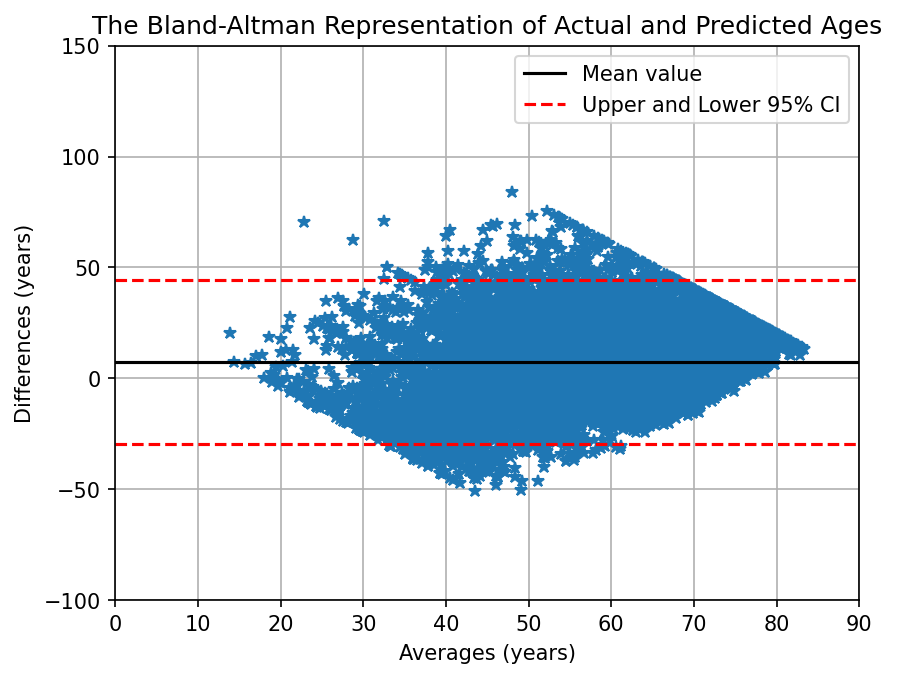

In [66]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'nih_age_full_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_age_full_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

354/354 [==============================] - 0s 702us/step
RMSE is: 26.53080959615438, MAE is: 21.198503682026818, R2  is: -1.5132938935478943, correlation coefficient  is 0.057043917058268424
Mean-1.96SD is -25.51 and  Mean+1.96SD is 57.49


(-100.0, 150.0)

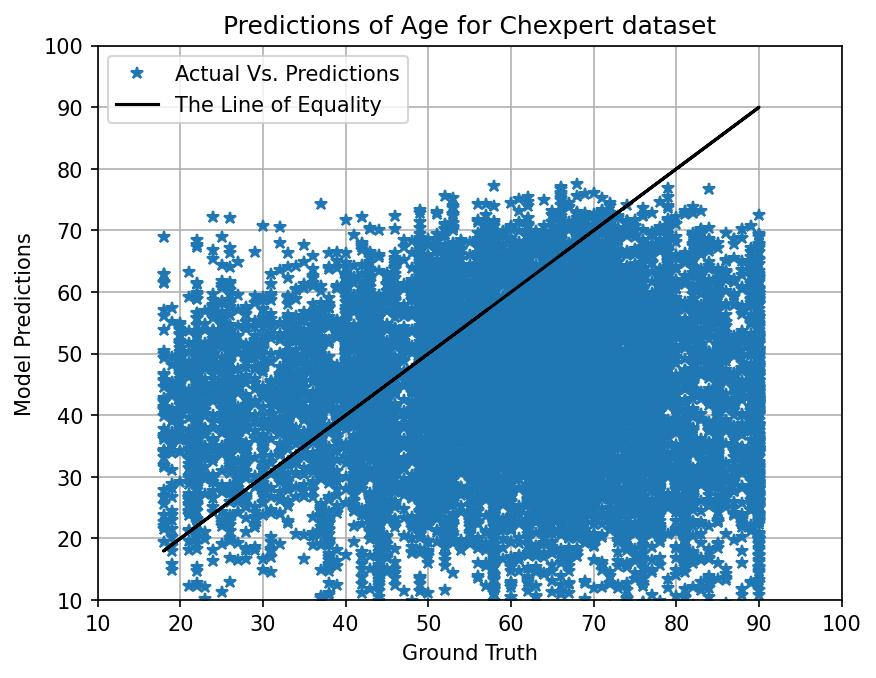

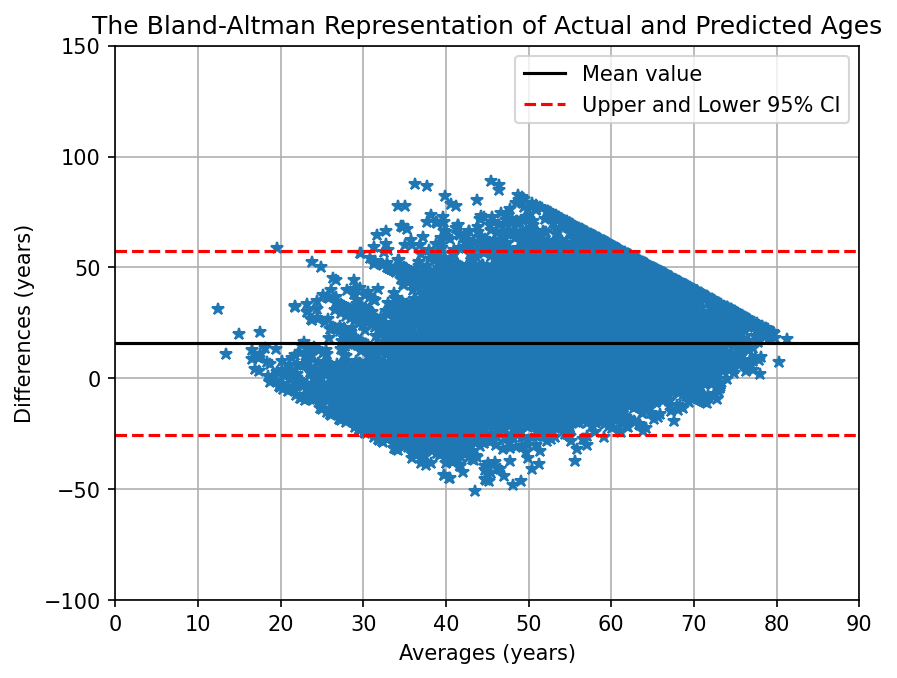

In [67]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'nih_age_segment_0_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_age_segment_0_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

354/354 [==============================] - 0s 687us/step
RMSE is: 20.991939067311325, MAE is: 16.966607221431314, R2  is: -0.5734298483297409, correlation coefficient  is 0.05714897626031899
Mean-1.96SD is -29.09 and  Mean+1.96SD is 46.12


(-100.0, 150.0)

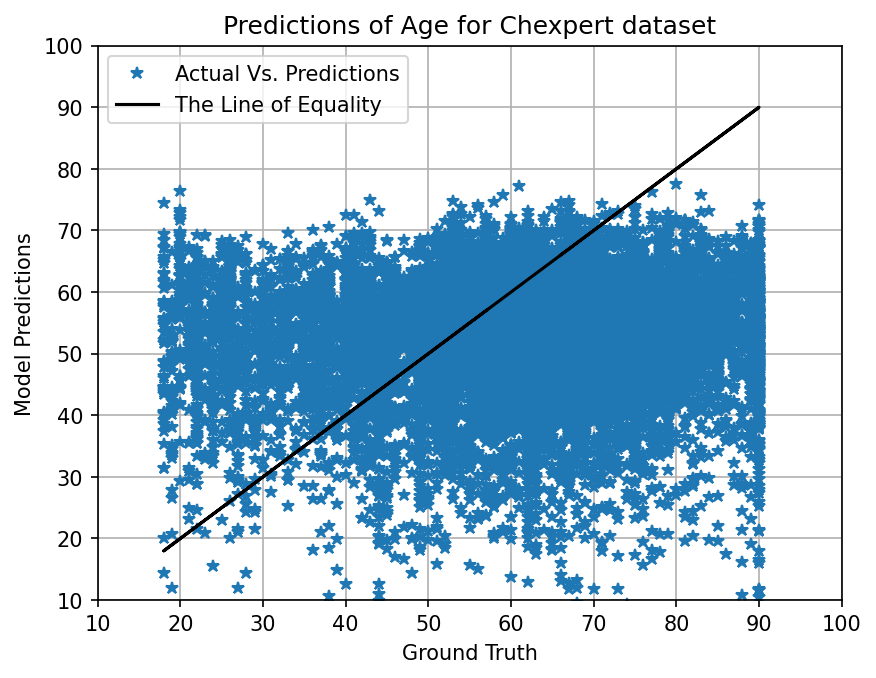

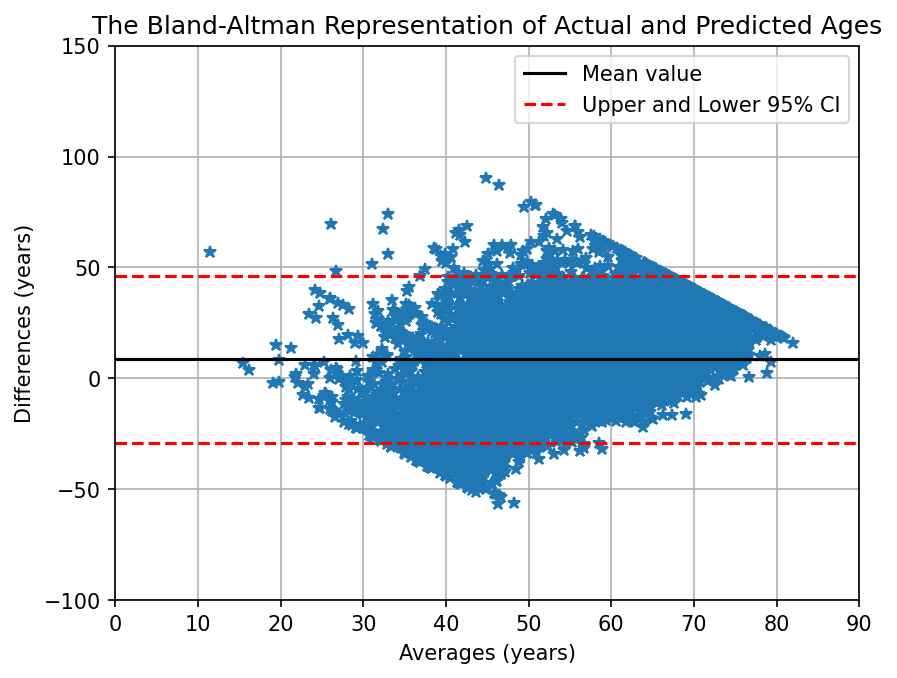

In [68]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'nih_age_segment_1_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_age_segment_1_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

354/354 [==============================] - 0s 679us/step
RMSE is: 24.212206800244743, MAE is: 19.828165015952415, R2  is: -1.0932014151371563, correlation coefficient  is 0.09438220006365448
Mean-1.96SD is -22.15 and  Mean+1.96SD is 52.23


(-100.0, 150.0)

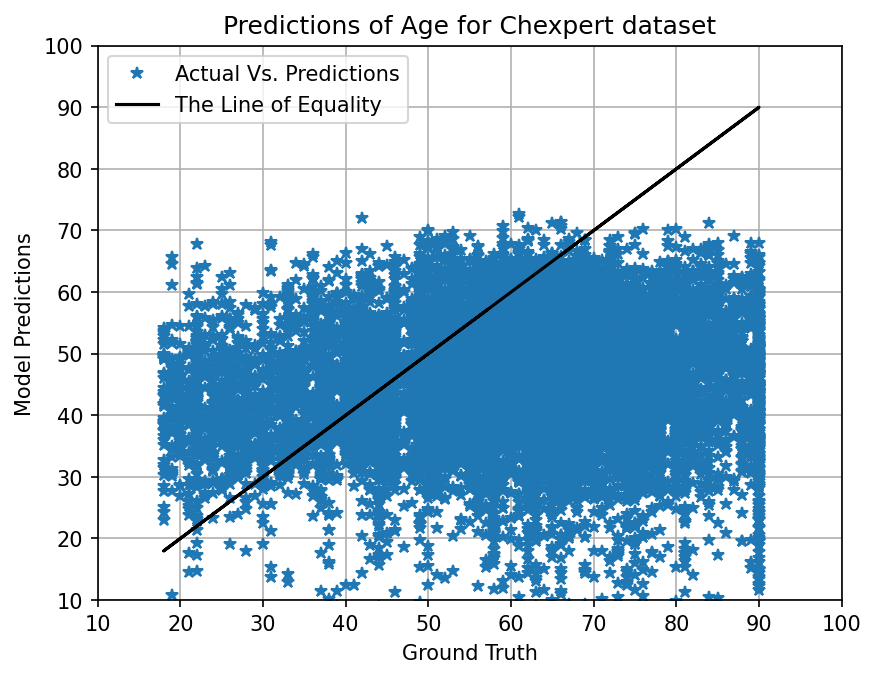

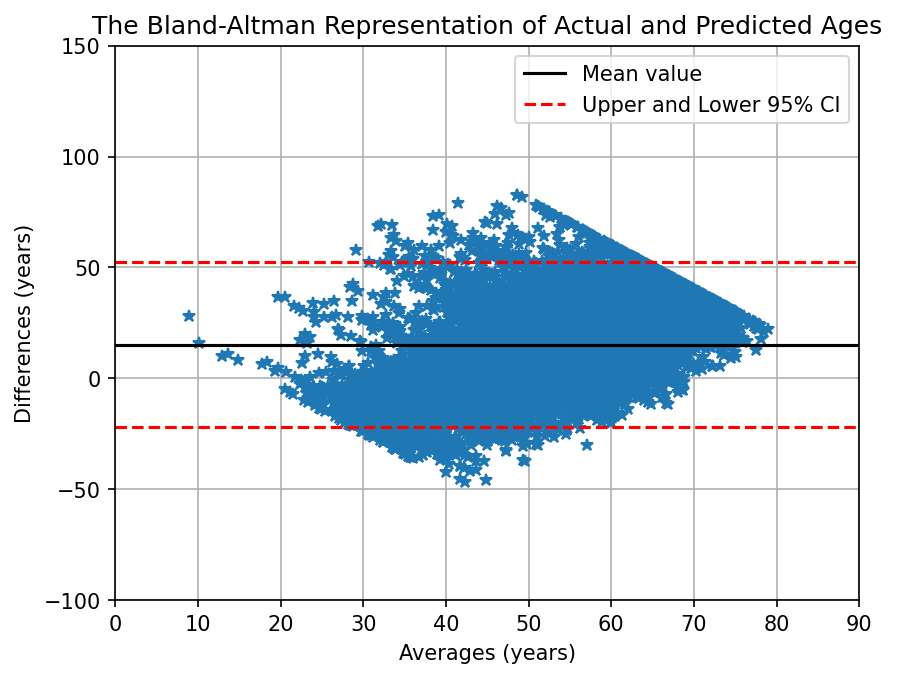

In [69]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'nih_age_segment_2_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_age_segment_2_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

354/354 [==============================] - 0s 648us/step
RMSE is: 24.381630093480435, MAE is: 19.21477502899276, R2  is: -1.1225979798266637, correlation coefficient  is 0.09683861382533544
Mean-1.96SD is -29.95 and  Mean+1.96SD is 53.62


(-100.0, 150.0)

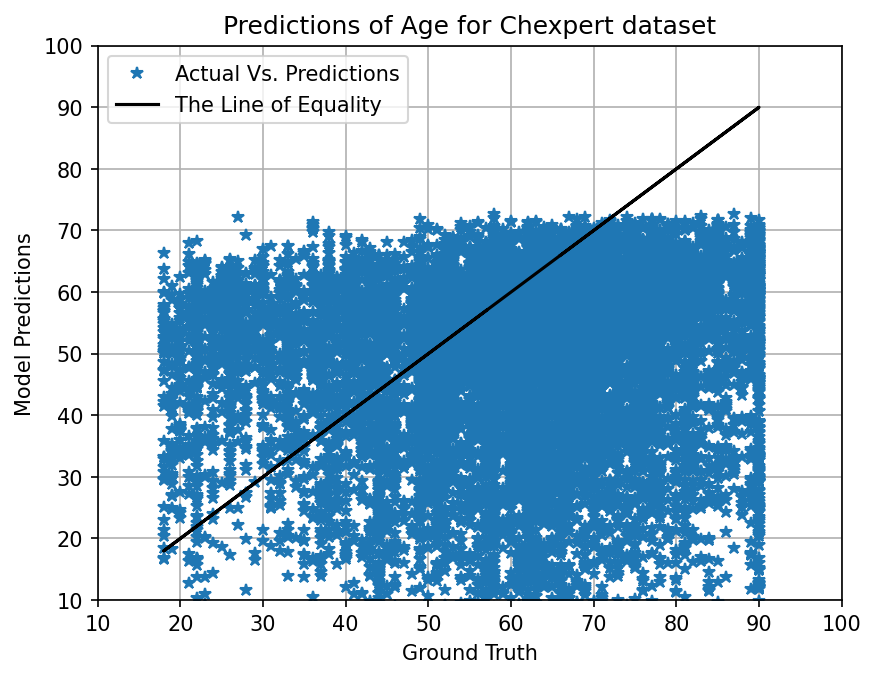

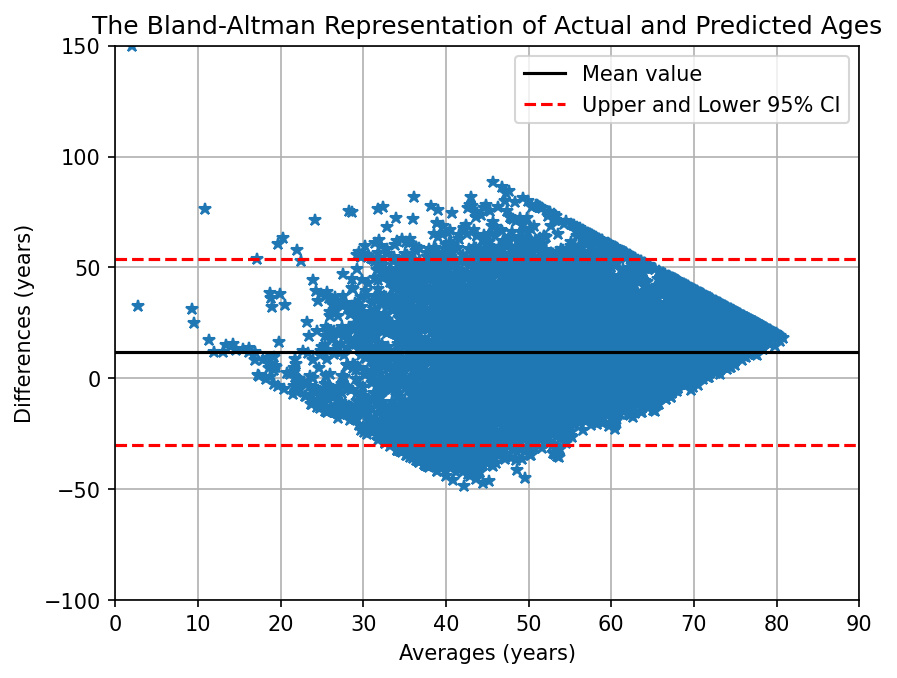

In [70]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'nih_age_segment_3_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_age_segment_3_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

420/420 [==============================] - 0s 870us/step
RMSE is: 18.770507223656498, MAE is: 14.675299370979621, R2  is: -0.44908186001681893, correlation coefficient  is 0.2987685298048882
Mean-1.96SD is -26.89 and  Mean+1.96SD is 41.16


(-100.0, 150.0)

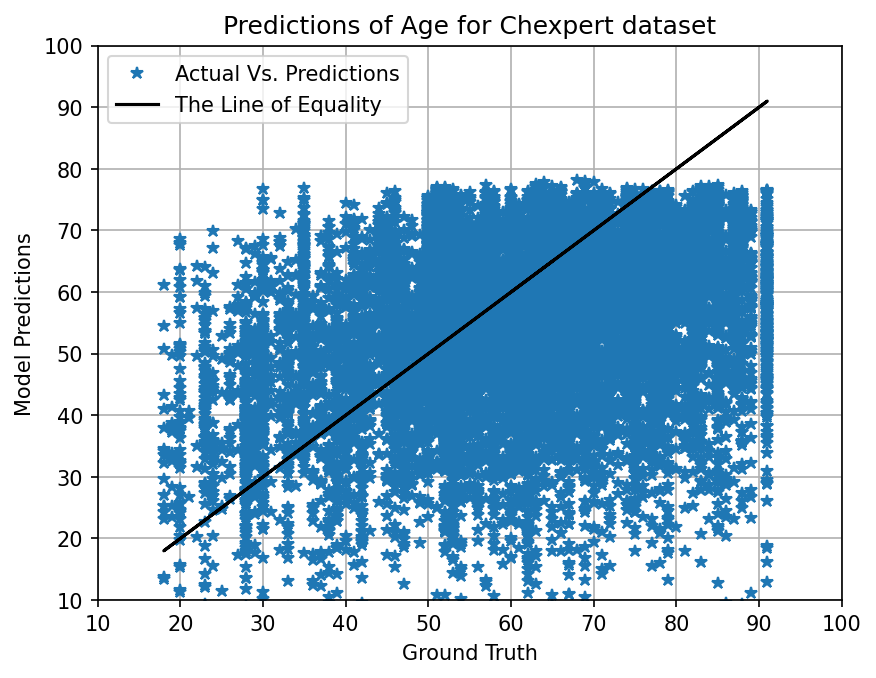

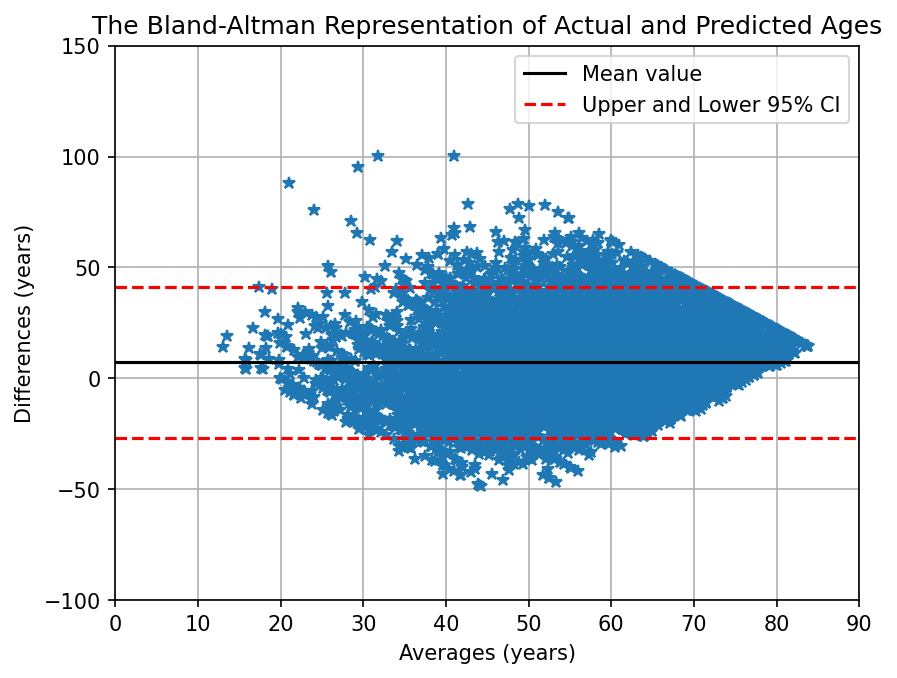

In [71]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'nih_age_full_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_age_full_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

420/420 [==============================] - 0s 644us/step
RMSE is: 20.698213577294933, MAE is: 16.467069756816684, R2  is: -0.7620029488278572, correlation coefficient  is 0.16370571250092153
Mean-1.96SD is -24.66 and  Mean+1.96SD is 45.47


(-100.0, 150.0)

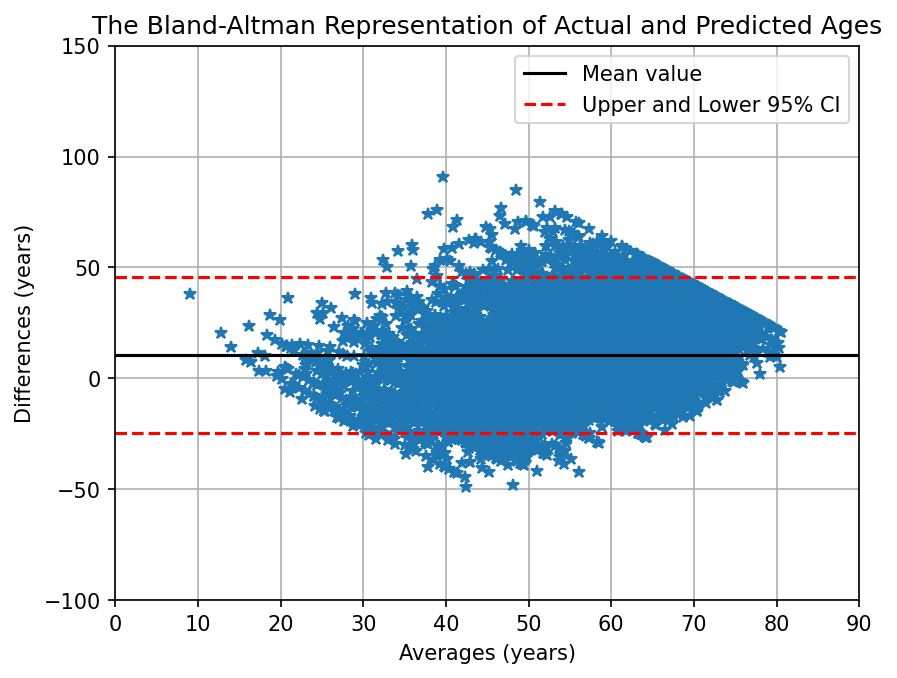

In [72]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'nih_age_segment_0_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_age_segment_0_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

In [73]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'nih_age_segment_1_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_age_segment_1_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

420/420 [==============================] - 1s 1ms/step
RMSE is: 21.570757572174863, MAE is: 17.28616084533922, R2  is: -0.9136904908113963, correlation coefficient  is 0.17813023042723147
Mean-1.96SD is -22.62 and  Mean+1.96SD is 47.06


(-100.0, 150.0)

420/420 [==============================] - 0s 638us/step
RMSE is: 21.87569629928683, MAE is: 17.63520163458122, R2  is: -0.9681793632454239, correlation coefficient  is 0.11705792152031007
Mean-1.96SD is -23.09 and  Mean+1.96SD is 47.75


(-100.0, 150.0)

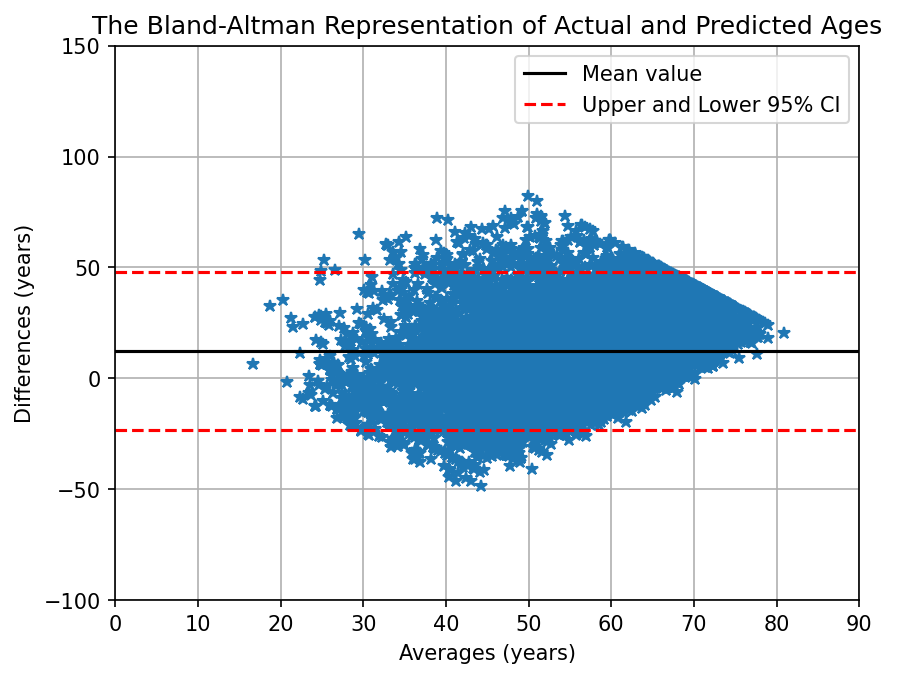

In [74]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'nih_age_segment_2_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_age_segment_2_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])

420/420 [==============================] - 0s 689us/step
RMSE is: 23.856511992218394, MAE is: 18.65058223902846, R2  is: -1.3407487301929946, correlation coefficient  is 0.15419312824155348
Mean-1.96SD is -25.20 and  Mean+1.96SD is 52.07


(-100.0, 150.0)

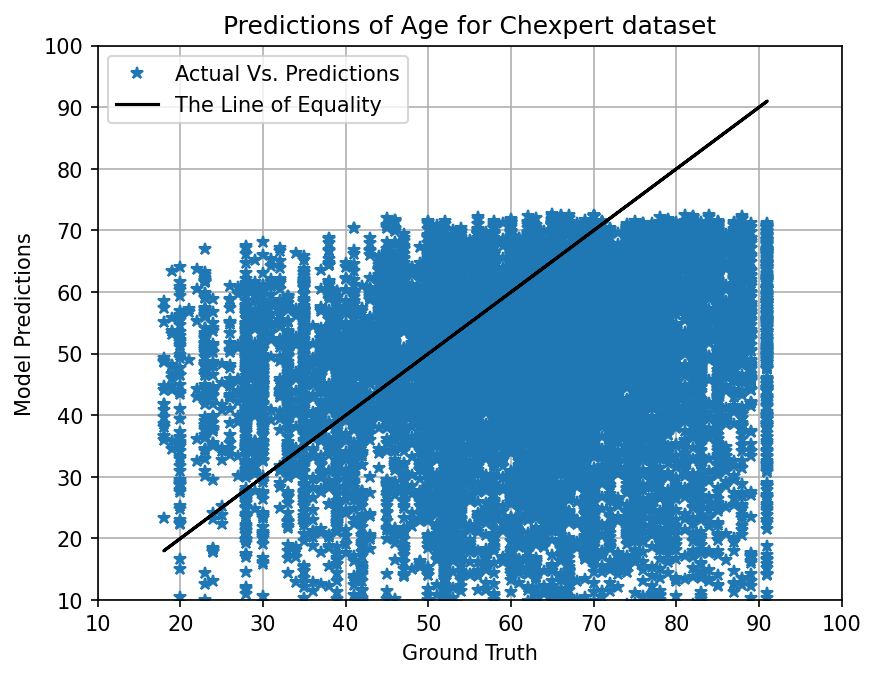

In [75]:
# chexpert second segment age ful model eevaluated by MIMIC
name = 'nih_age_segment_3_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_age_segment_3_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))

y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])
mks_y = y_predict_chex_total<=90
y_predict_chex_total = y_predict_chex_total[mks_y]
y_chex_total  = y_chex_total[mks_y[:,0]]

plt.figure(dpi=150)
plt.plot(y_chex_total,y_predict_chex_total,'*',label='Actual Vs. Predictions')
plt.plot(y_chex_total,y_chex_total,'k',label='The Line of Equality')
plt.legend()
plt.grid(which='both')
plt.xlabel('Ground Truth')
plt.ylabel('Model Predictions')
plt.title('Predictions of Age for Chexpert dataset')
plt.xlim([10, 100])
plt.ylim([10, 100])

rmse, mae,r2,cr = regression_metrics(y_actual=y_chex_total,y_estimetd=y_predict_chex_total)
print("RMSE is: {}, MAE is: {}, R2  is: {}, correlation coefficient  is {}".format(rmse,mae,r2,cr[0,1]))
bland_altman_plot(y_actual=y_chex_total, y_estimetd=y_predict_chex_total)

plt.xlim([0, 90])
plt.ylim([-100, 150])